## 課題① Kickstarter Projects
- クラウドファンデイングが成功するか(state)を予測

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

### 1. データの読み込み

ks-projects-201801.csvのColumnについて
1. ID
2. name
3. category
4. main_category
5. currency：通貨
6. deadline：クラウドファンディングの締切日
7. goal：目標額
8. launched：開始日時
9. pledged：出資金額。最終的に集まった金額？<font color="Red">【予測に使えない項目】</font>
10. state：状態
11. backers：出資者数。出資した人数<font color="Red">【予測に使えない項目】</font>
12. country：国
13. usd pledged：米ドルでの出資金額（KSによる変換）<font color="Red">【予測に使えない項目】</font>
14. usd_pledged_real：米ドルでの出資金額（fixer.io apiによる変換）<font color="Red">【予測に使えない項目】</font>
15. usd_goal_real：米ドルでの目標額

In [2]:
df_kp = pd.read_csv("./ks-projects-201801.csv")

display(df_kp.head())
#統計量をすべて出力
#平均=mean
#std=標準偏差
display(df_kp.describe())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [3]:
#欠損値チェック
df_kp.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [4]:
df_kp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [5]:
#categoryの要素の個数を表示
df_kp.category.value_counts()

Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Printing               238
Makerspaces            238
M

In [6]:
#stateの要素の個数を表示
df_kp.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

#### stateの値
- failed：失敗
- successful：成功
- canceled：キャンセル
- undefined：未定義
- live：実行中
- suspended：一時停止

### 2.stateが 成功(successful) 又は 失敗(failed) のデータのみを取得

In [7]:
df_kp=df_kp[(df_kp.state == 'failed') | (df_kp.state == 'successful')]
display(df_kp.head())
display(df_kp.describe())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.316750e+05,3.316750e+05,3.316750e+05,331675.000000,3.314650e+05,3.316750e+05,3.316750e+05
mean,1.074271e+09,4.425157e+04,1.058400e+04,116.381581,7.684569e+03,9.943461e+03,4.151000e+04
std,6.191924e+08,1.117917e+06,1.015917e+05,965.427268,8.320938e+04,9.673293e+04,1.108930e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.371725e+08,2.000000e+03,5.000000e+01,2.000000,2.500000e+01,5.000000e+01,2.000000e+03
50%,1.074573e+09,5.000000e+03,7.820000e+02,15.000000,5.020000e+02,7.880000e+02,5.000000e+03
75%,1.609844e+09,1.500000e+04,4.657000e+03,63.000000,3.421000e+03,4.608000e+03,1.500000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [8]:
#stateの要素の個数を表示
df_kp.state.value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

### 3.stateの値を1(成功)、0(失敗)に変更

In [9]:
#stateがsuccessful(成功)の場合、stateに1を設定
#stateがfailed(失敗)の場合、stateに0を設定
df_kp.loc[df_kp.state=='successful',["state"]]=1
df_kp.loc[df_kp.state=='failed',["state"]]=0
display(df_kp.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,US,1.0,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224,US,52375.0,52375.0,50000.00


### 4.クラウドファンディングの期間（日数）を計算
- deadline(締切日)～launched(開始日時)の期間

In [10]:
#deadline(締切日)とlaunched(開始日時)を時刻型に変換
df_kp['deadline'] = pd.to_datetime(df_kp['deadline'], format='%Y-%m-%d %H:%M:%S')
df_kp['launched'] = pd.to_datetime(df_kp['launched'], format='%Y-%m-%d %H:%M:%S')

#クラウドファンディングの期間（日数）を計算
df_kp['period']=(df_kp['deadline'] - df_kp['launched']).dt.days

display(df_kp.head())
display(df_kp.describe())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,period
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,US,100.0,2421.0,30000.00,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,US,220.0,220.0,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,US,1.0,1.0,5000.00,29
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224,US,52375.0,52375.0,50000.00,34


,ID,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,period
count,3.316750e+05,3.316750e+05,3.316750e+05,331675.000000,331675.000000,3.314650e+05,3.316750e+05,3.316750e+05,331675.000000
mean,1.074271e+09,4.425157e+04,1.058400e+04,0.403877,116.381581,7.684569e+03,9.943461e+03,4.151000e+04,32.954902
std,6.191924e+08,1.117917e+06,1.015917e+05,0.490674,965.427268,8.320938e+04,9.673293e+04,1.108930e+06,12.713329
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,0.000000
25%,5.371725e+08,2.000000e+03,5.000000e+01,0.000000,2.000000,2.500000e+01,5.000000e+01,2.000000e+03,29.000000
50%,1.074573e+09,5.000000e+03,7.820000e+02,0.000000,15.000000,5.020000e+02,7.880000e+02,5.000000e+03,29.000000
75%,1.609844e+09,1.500000e+04,4.657000e+03,1.000000,63.000000,3.421000e+03,4.608000e+03,1.500000e+04,35.000000
max,2.147476e+09,1.000000e+08,2.033899e+07,1.000000,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08,91.000000


### 5.不要な列を除く
- nullあり：name
- 不要なデータ：ID、category
- 予測に使えない：pledged, backers, usd pledged, usd_pledged_real
- goal：usd_goal_realと重複しているため
- deadline、launched：日数に変換したため

In [11]:
#不要列の削除
df_kp=df_kp.drop(columns=['ID', 'name', 'category', 'deadline', 'goal', 'launched', 'pledged', 'backers' ,'usd pledged', 'usd_pledged_real'])
display(df_kp.head())
display(df_kp.describe())

,main_category,currency,state,country,usd_goal_real,period
0,Publishing,GBP,0,GB,1533.95,58
1,Film & Video,USD,0,US,30000.00,59
2,Film & Video,USD,0,US,45000.00,44
3,Music,USD,0,US,5000.00,29
5,Food,USD,1,US,50000.00,34


,state,usd_goal_real,period
count,331675.000000,3.316750e+05,331675.000000
mean,0.403877,4.151000e+04,32.954902
std,0.490674,1.108930e+06,12.713329
min,0.000000,1.000000e-02,0.000000
25%,0.000000,2.000000e+03,29.000000
50%,0.000000,5.000000e+03,29.000000
75%,1.000000,1.500000e+04,35.000000
max,1.000000,1.663614e+08,91.000000


In [12]:
#欠損値チェック
df_kp.isnull().sum()

main_category    0
currency         0
state            0
country          0
usd_goal_real    0
period           0
dtype: int64

In [13]:
df_kp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 6 columns):
main_category    331675 non-null object
currency         331675 non-null object
state            331675 non-null int64
country          331675 non-null object
usd_goal_real    331675 non-null float64
period           331675 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 17.7+ MB


In [14]:
#main_categoryの要素の個数を表示
df_kp.main_category.value_counts()

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

In [15]:
#currencyの要素の個数を表示
df_kp.currency.value_counts()

USD    261511
GBP     29476
EUR     14378
CAD     12375
AUD      6621
SEK      1510
MXN      1411
NZD      1274
DKK       929
CHF       652
NOK       584
HKD       477
SGD       454
JPY        23
Name: currency, dtype: int64

In [16]:
#countryの要素の個数を表示
df_kp.country.value_counts()

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64

### 6.countryの「N,0"」を「NO」に変換

In [17]:
#countryの「N,0"」を「NO（ノルウェー）」と判断して「NO」に変換
df_kp.loc[df_kp.country=='N,0"',["country"]]='NO'

#countryの要素の個数を表示
df_kp.country.value_counts()

US    261360
GB     29454
CA     12370
AU      6616
DE      3436
FR      2520
NL      2411
IT      2369
ES      1873
SE      1509
MX      1411
NZ      1274
DK       926
NO       792
IE       683
CH       652
BE       523
AT       485
HK       477
SG       454
LU        57
JP        23
Name: country, dtype: int64

### 7.countryを大陸別に変換
- 北アメリカ：North America
- ヨーロッパ：Europe
- オセアニア：Oceania
- アジア：Asia
<br><br>
US  　アメリカ　　　　　North America<br>
GB  　イギリス　　　　　Europe<br>
CA  　カナダ　　　　　　North America<br>
AU  　オーストラリア　　Oceania<br>
DE  　ドイツ　　　　　　Europe<br>
FR  　フランス　　　　　Europe<br>
NL  　オランダ　　　　　Europe<br>
IT  　イタリア　　　　　Europe<br>
ES  　スペイン　　　　　Europe<br>
SE  　スウェーデン　　　Europe<br>
MX  　メキシコ　　　　　North America<br>
NZ  　ニュージーランド　Oceania<br>
DK  　デンマーク　　　　Europe<br>
IE  　アイルランド　　　Europe<br>
CH  　スイス　　　　　　Europe<br>
NO  　ノルウェー　　　　Europe<br>
BE  　ベルギー　　　　　Europe<br>
AT  　オーストリア　　　Europe<br>
HK  　香港　　　　　　　Asia<br>
SG  　シンガポール　　　Asia<br>
LU  　ルクセンブルク　　Europe<br>
JP  　日本　　　　　　　Asia<br>

In [18]:
#countryを大陸別に変換
df_kp.loc[df_kp.country=='US'  ,["country"]]='North_America'
df_kp.loc[df_kp.country=='GB'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='CA'  ,["country"]]='North_America'
df_kp.loc[df_kp.country=='AU'  ,["country"]]='Oceania'
df_kp.loc[df_kp.country=='DE'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='FR'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='NL'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='IT'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='ES'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='SE'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='MX'  ,["country"]]='North_America'
df_kp.loc[df_kp.country=='NZ'  ,["country"]]='Oceania'
df_kp.loc[df_kp.country=='DK'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='IE'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='CH'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='NO'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='BE'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='AT'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='HK'  ,["country"]]='Asia'
df_kp.loc[df_kp.country=='SG'  ,["country"]]='Asia'
df_kp.loc[df_kp.country=='N,0"',["country"]]='Europe'
df_kp.loc[df_kp.country=='LU'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='JP'  ,["country"]]='Asia'

display(df_kp.head())

,main_category,currency,state,country,usd_goal_real,period
0,Publishing,GBP,0,Europe,1533.95,58
1,Film & Video,USD,0,North_America,30000.00,59
2,Film & Video,USD,0,North_America,45000.00,44
3,Music,USD,0,North_America,5000.00,29
5,Food,USD,1,North_America,50000.00,34


In [19]:
#countryの要素の個数を表示
df_kp.country.value_counts()

North_America    275141
Europe            47690
Oceania            7890
Asia                954
Name: country, dtype: int64

## ①文字データを数値に置き換えて、モデル作成
### 8.文字データの値を数値に変換

In [20]:
from sklearn.preprocessing import LabelEncoder

#LabelEncoderのインスタンスを生成
le = LabelEncoder()

#df_kpをコピーして、df_kp2を作成
df_kp2=df_kp.copy()

#main_categoryを数値に変換
le = le.fit(df_kp2.main_category)
df_kp2.main_category = le.transform(df_kp2.main_category)

#currencyを数値に変換
le = le.fit(df_kp2.currency)
df_kp2.currency = le.transform(df_kp2.currency)

#countryを数値に変換
le = le.fit(df_kp2.country)
df_kp2.country = le.transform(df_kp2.country)

display(df_kp2.head())
df_kp2.describe()

,main_category,currency,state,country,usd_goal_real,period
0,12,5,0,1,1533.95,58
1,6,13,0,2,30000.00,59
2,6,13,0,2,45000.00,44
3,10,13,0,2,5000.00,29
5,7,13,1,2,50000.00,34


,main_category,currency,state,country,usd_goal_real,period
count,331675.000000,331675.000000,331675.000000,331675.000000,3.316750e+05,331675.000000
mean,7.483410,11.081227,0.403877,1.874250,4.151000e+04,32.954902
std,3.931466,3.878572,0.490674,0.404062,1.108930e+06,12.713329
min,0.000000,0.000000,0.000000,0.000000,1.000000e-02,0.000000
25%,5.000000,13.000000,0.000000,2.000000,2.000000e+03,29.000000
50%,7.000000,13.000000,0.000000,2.000000,5.000000e+03,29.000000
75%,10.000000,13.000000,1.000000,2.000000,1.500000e+04,35.000000
max,14.000000,13.000000,1.000000,3.000000,1.663614e+08,91.000000


In [21]:
df_kp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 6 columns):
main_category    331675 non-null int32
currency         331675 non-null int32
state            331675 non-null int64
country          331675 non-null int32
usd_goal_real    331675 non-null float64
period           331675 non-null int64
dtypes: float64(1), int32(3), int64(2)
memory usage: 13.9 MB


### 9.グラフを作成

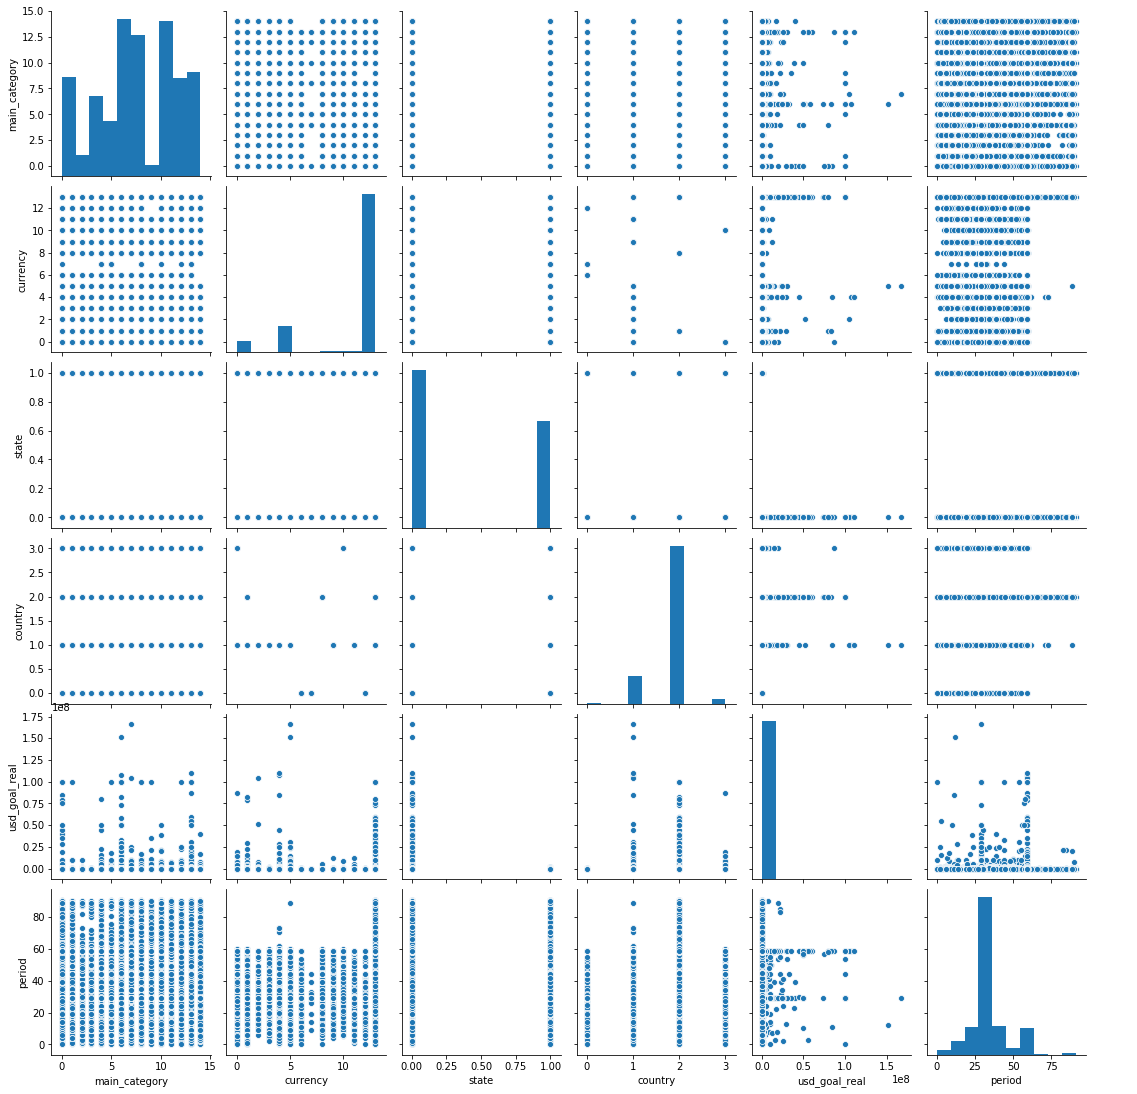

In [22]:
#散布図行列　ヒストグラムと散布図を全てのデータで表示
sns.pairplot(df_kp2)

散布図行列より、<font color="Red">stateと相関がありそうなのは usd_goal_real, period？</font><br>
<font color="blue">目的変数：state</font><br>
<font color="blue">説明変数：usd_goal_real, period</font>

### 10.Scikit-learnを用いてロジスティック回帰を実装（数値変換版）
- stateが1になるかどうかを予測

In [23]:
#y:目的変数、X:説明変数
y = df_kp2["state"].values
X = df_kp2[["usd_goal_real", "period"]].values
#loss='log(=ロジスティクス回帰)'
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
#学習する=fix
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

w0 = 8748.701, w1 = -689.430, w2 = 220750.213


In [24]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -15.417
正答率 = 55.364%


### 11.混同行列（数値変換版）

In [25]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,83599,114120
正解 = 成功,33927,100029


### 12.Accuracy、Recall、Precisionを計算（数値変換版）

In [26]:
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# 「クラウドファンデイングが成功する」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

適合率（Precision） = 46.710%
再現率（Recall） = 74.673%
F1値（F1-score） = 57.471%


- -------------------------------------------

## ②文字データをダミー変数に置き換えて、モデル作成
### 13.文字データをダミー変数に置き換え

In [27]:
#以下のpd.get_dummies(df_kp)を実行するとメモリーエラーになったため、1列ずつダミー変数に置き換える
#df_kp=pd.get_dummies(df_kp)

#main_categoryをダミー変数に置き換える
df_kp_main_category=pd.get_dummies(df_kp.main_category,prefix="main_category")

#currencyをダミー変数に置き換える
df_kp_currency=pd.get_dummies(df_kp.currency,prefix="currency")

#countryをダミー変数に置き換える
df_kp_country=pd.get_dummies(df_kp.country,prefix="country")

In [28]:
#main_categoryのダミー変数
display(df_kp_main_category.head())

,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [29]:
#currencyのダミー変数
display(df_kp_currency.head())

,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [30]:
#countryのダミー変数
display(df_kp_country.head())

,country_Asia,country_Europe,country_North_America,country_Oceania
0,0,1,0,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
5,0,0,1,0


In [31]:
#ダミー変数で作成したDataFrameを結合
df_kp3=pd.concat([df_kp,  df_kp_main_category], axis=1)
df_kp3=pd.concat([df_kp3, df_kp_currency], axis=1)
df_kp3=pd.concat([df_kp3, df_kp_country], axis=1)
display(df_kp3.head())
df_kp3.info()

,main_category,currency,state,country,usd_goal_real,period,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,...,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,country_Asia,country_Europe,country_North_America,country_Oceania
0,Publishing,GBP,0,Europe,1533.95,58,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Film & Video,USD,0,North_America,30000.00,59,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,Film & Video,USD,0,North_America,45000.00,44,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,Music,USD,0,North_America,5000.00,29,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
5,Food,USD,1,North_America,50000.00,34,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 39 columns):
main_category                 331675 non-null object
currency                      331675 non-null object
state                         331675 non-null int64
country                       331675 non-null object
usd_goal_real                 331675 non-null float64
period                        331675 non-null int64
main_category_Art             331675 non-null uint8
main_category_Comics          331675 non-null uint8
main_category_Crafts          331675 non-null uint8
main_category_Dance           331675 non-null uint8
main_category_Design          331675 non-null uint8
main_category_Fashion         331675 non-null uint8
main_category_Film & Video    331675 non-null uint8
main_category_Food            331675 non-null uint8
main_category_Games           331675 non-null uint8
main_category_Journalism      331675 non-null uint8
main_category_Music           331675 non-null uint8


### 14.Scikit-learnを用いてロジスティック回帰を実装（ダミー変数版）
- stateが1になるかどうかを予測     
- <font color="Red">説明変数が多いため、グラフをどのように書けばよいのか不明。とりあえず全て説明変数に使用！</font>

In [32]:
#y:目的変数、X:説明変数
y = df_kp3["state"].values
X = df_kp3[["usd_goal_real",
            "period",
            "main_category_Art",
            "main_category_Comics",
            "main_category_Crafts",
            "main_category_Dance",
            "main_category_Design",
            "main_category_Fashion",
            "main_category_Film & Video",
            "main_category_Food",
            "main_category_Games",
            "main_category_Journalism",
            "main_category_Music",
            "main_category_Photography",
            "main_category_Publishing",
            "main_category_Technology",
            "main_category_Theater",
            "currency_AUD",
            "currency_CAD",
            "currency_CHF",
            "currency_DKK",
            "currency_EUR",
            "currency_GBP",
            "currency_HKD",
            "currency_JPY",
            "currency_MXN",
            "currency_NOK",
            "currency_NZD",
            "currency_SEK",
            "currency_SGD",
            "currency_USD",
            "country_Asia",
            "country_Europe",
            "country_North_America",
            "country_Oceania"]].values
#X = df_kp3[["usd_goal_real", "period", "country_Asia", "country_Europe", "country_North_America", "country_Oceania"]].values
#loss='log(=ロジスティクス回帰)'
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
#学習する=fix
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

w0 = 8288.645, w1 = -639.293, w2 = 205397.292


In [33]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -15.419
正答率 = 55.358%


### 15.混同行列（ダミー変数版）

In [34]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,83486,114233
正解 = 成功,33834,100122


### 16.Accuracy、Recall、Precisionを計算（ダミー変数版）

In [35]:
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# 「クラウドファンデイングが成功する」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

適合率（Precision） = 46.708%
再現率（Recall） = 74.742%
F1値（F1-score） = 57.490%
